         Date     Close      High       Low      Open     Volume
0  2010-06-29  1.592667  1.666667  1.169333  1.266667  281494500
1  2010-06-30  1.588667  2.028000  1.553333  1.719333  257806500
2  2010-07-01  1.464000  1.728000  1.351333  1.666667  123282000
3  2010-07-02  1.280000  1.540000  1.247333  1.533333   77097000
4  2010-07-06  1.074000  1.333333  1.055333  1.333333  103003500
Epoch [1/10], Loss: 0.0165
Epoch [2/10], Loss: 0.0005
Epoch [3/10], Loss: 0.0004
Epoch [4/10], Loss: 0.0004
Epoch [5/10], Loss: 0.0004
Epoch [6/10], Loss: 0.0004
Epoch [7/10], Loss: 0.0004
Epoch [8/10], Loss: 0.0003
Epoch [9/10], Loss: 0.0003
Epoch [10/10], Loss: 0.0003


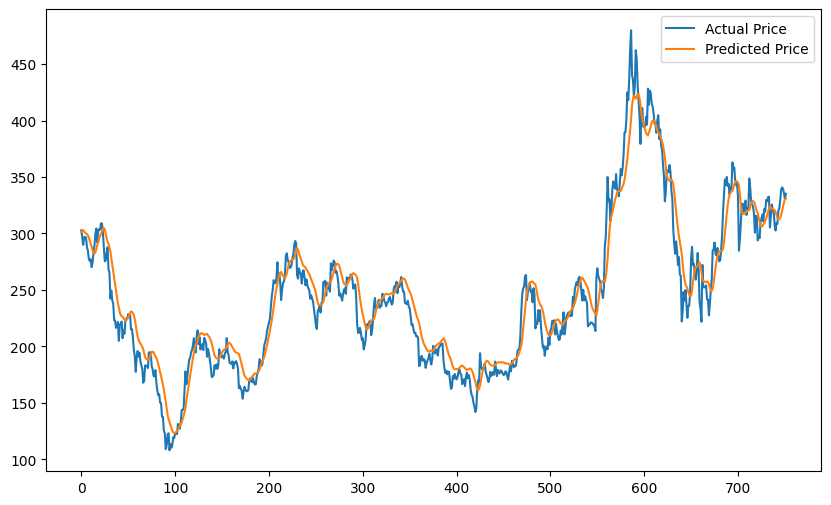

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

# 1️⃣ Load your uploaded CSV
file_path = '/content/sample_data/DATASET/Tesla_stock_data.csv'
data = pd.read_csv(file_path)
print(data.head())

# Assume the dataset has a 'Close' column
prices = data['Close'].values.reshape(-1, 1)

# 2️⃣ Normalize prices
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(prices)

# 3️⃣ Create sequences for LSTM
def create_sequences(data, seq_length=50):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 50
X, y = create_sequences(scaled_prices, seq_length)

# Split into train/test sets
split = int(len(X) * 0.8)
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)

# 4️⃣ Define LSTM model
class StockLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2, output_size=1):
        super(StockLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

model = StockLSTM()

# 5️⃣ Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 6️⃣ Training
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")

# 7️⃣ Evaluate
model.eval()
with torch.no_grad():
    predictions = model(X_test).numpy()
    predictions = scaler.inverse_transform(predictions)
    actual = scaler.inverse_transform(y_test.numpy())

# 8️⃣ Plot results
plt.figure(figsize=(10,6))
plt.plot(actual, label='Actual Price')
plt.plot(predictions, label='Predicted Price')
plt.legend()
plt.show()
